# Extract Only the Teacher's Audio

Since the Temi transcriptions include time stamps I want to see if I can use those to cut out the avatar voices to get a .wav file with just the teacher talking. 

For this code I download a Temi transcript with the following selections: 
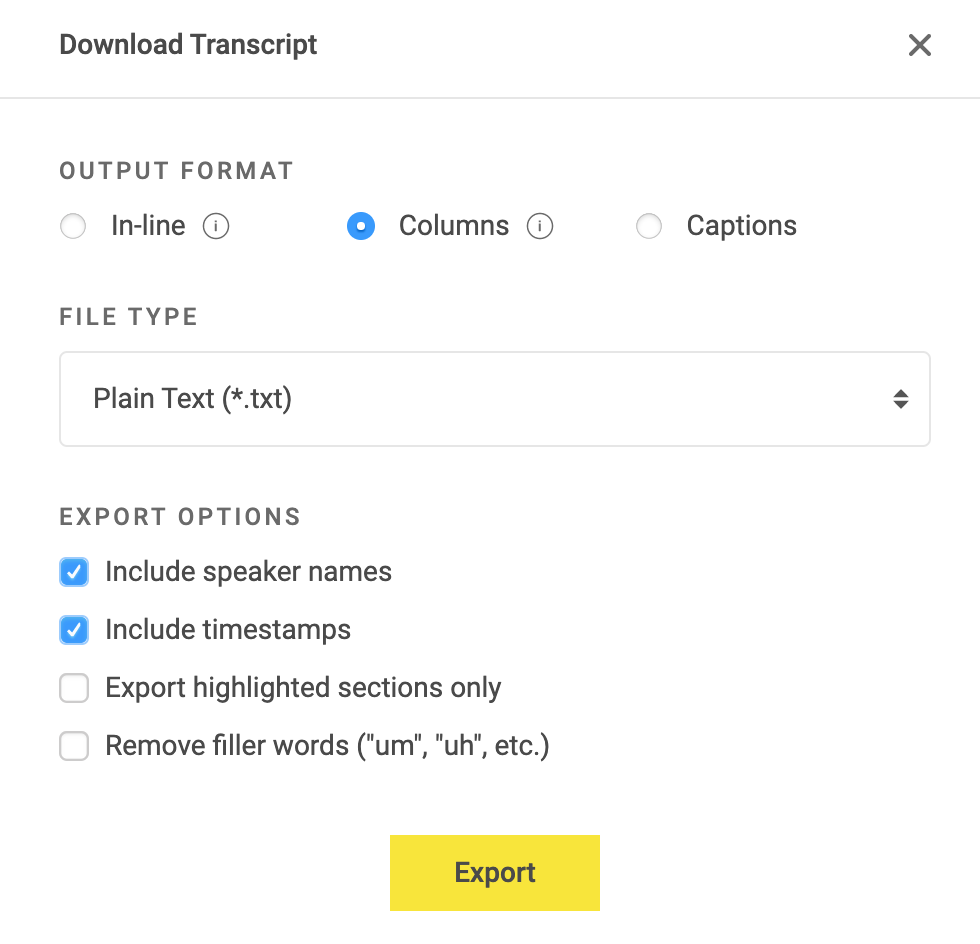

The resulting text file looks like this and can read it into a pandas dataframe to extract the timestamp and speaker labels I need.
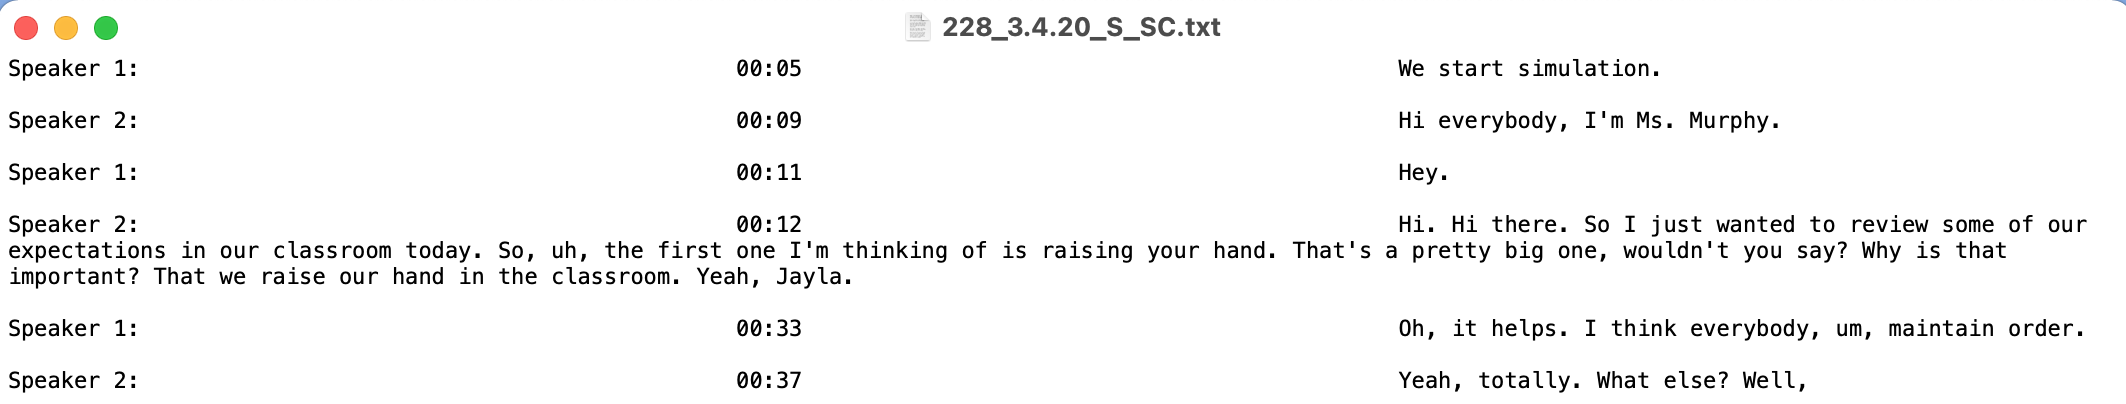

In [1]:
import os
from pydub import AudioSegment
import wave
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


In [2]:
# File paths
m4a_path = './data/m4a_files/'
wav_path = './data/wav_files/' # Full .wav file
transcript_path = './data/transcript_files/'
teacher_wav_path = './data/teacher_wav_files/' # .wav file with just teacher

In [3]:
# File name to test on
file_name = "228_3.4.20_S_SC"

In [4]:
def convert_m4a_to_wav(file_name, m4a_path, wav_path):
    '''
    Convert an .m4a audio file to a .wav audio file using PyDub.

    Inputs:
        file_name (str): name of file (without extension)
        m4a_path (str): directory path for input .m4a file
        wav_path (str): directory path for output .wav file

    '''
    
    # Load the m4a file
    audio = AudioSegment.from_file(m4a_path + file_name + '.m4a', format = 'm4a')
    
    # Set the desired sample rate and bit depth
    desired_sample_rate = 44100
    desired_sample_width = 2  # 16-bit depth

    # Resample the audio to the desired sample rate
    resampled_audio = audio.set_frame_rate(desired_sample_rate)

    # Set the bit depth to the desired value
    converted_audio = resampled_audio.set_sample_width(desired_sample_width)

    # Export the converted audio to a new WAV file
    converted_audio.export(wav_path + file_name + '.wav', format="wav")
    
    


In [5]:
# Create empty directories for wav files (if it doesn't exist)
if not os.path.exists(wav_path):
    os.makedirs(wav_path)

if not os.path.exists(teacher_wav_path):
    os.makedirs(teacher_wav_path)


In [6]:
convert_m4a_to_wav(file_name, m4a_path, wav_path)

In [7]:
def extract_teacher_timestamps(file_name, transcript_path, teacher_speaker_num):
    '''
    Create a list of timestamp pairs in between which the teacher is speaking
    
    file_name: name of original file
    transcript_path: directory containing transcripts
    teacher_speaker_num: integer of which speaker number in the transcript corresponds to the teacher 
    
    '''
    
    # Read in transcript
    df = pd.read_csv(transcript_path + file_name + '.txt', 
                 engine = 'python', 
                 delimiter = "                                             ",
                 header = None)
    
    df.columns = ['Speaker', 'Timestamp', 'Text']

    # Create a column that converts the timestamps to seconds
    df['Timestamp_Secs'] = df['Timestamp'].apply(convert_time_to_seconds)
    
    # Create a column with pairs of timestamps
    df['Timestamp_Pairs'] = df.apply(create_timestamp_pairs, col = 'Timestamp_Secs', df = df, axis=1)
    
    # Filter to only the teacher
    df_teacher = df[df['Speaker'] == f'Speaker {teacher_speaker_num}:']
    
    # Get a list of the timestamp pairs
    timestamp_pairs = df_teacher.Timestamp_Pairs.to_list()
    
    return timestamp_pairs

In [8]:
def convert_time_to_seconds(timestamp):
    # Parse the timestamp as a datetime object
    time_obj = datetime.strptime(timestamp, '%M:%S')
    
    # Convert the datetime object to a timedelta object
    time_delta = timedelta(minutes=time_obj.minute, seconds=time_obj.second)
    
    # Convert the timedelta object to seconds
    return time_delta.total_seconds()

In [9]:
def create_timestamp_pairs(row, col, df):
    # Get the index of the current row
    index = row.name
    
    # Get the timestamp for the current row
    current_timestamp = row[col]

    # Check if there is a next row
    if index < len(df) - 1:
        # If there is, get the timestamp for the next row
        next_timestamp = df.loc[index + 1, col]
    else:
        # If there isn't, use the current timestamp value as a placeholder
        next_timestamp = current_timestamp

    # Create the tuple
    return (current_timestamp, next_timestamp)



In [10]:
def extract_teacher_audio(file_name, wav_path, teacher_wav_path, transcript_path, teacher_speaker_num):
    '''
    Extract the audio from the .wav file between each timestamp pair in the list.
    Saves as a new .wav file
    
    file_name: name of original .wav file
    wav_path: directory containing .wav file
    teacher_wav_path: directory to save .wav file with just teacher
    transcript_path: directory containing transcript files
    teacher_speaker_num: integer of which speaker number in the transcript corresponds to the teacher 
    
    '''
    # Get timestamp pairs 
    # (list of pairs of timestamps (in seconds) in between which the teacher is speaking)
    timestamp_pairs = extract_teacher_timestamps(file_name, transcript_path, 2)
    
    
    with wave.open(wav_path + file_name + '.wav', 'rb') as wave_file:
        # Get the number of frames and the frame rate
        num_frames = wave_file.getnframes()
        frame_rate = wave_file.getframerate()

        # Initialize a list to hold the audio segments
        segments = []
        
        # If the teacher was the last to speak the last timestamp pair will have the wrong end time
        # Do a quick check and update if needed
        final_timestamp_pair = timestamp_pairs[-1]
        duration = num_frames / float(frame_rate)
        if final_timestamp_pair[0] == final_timestamp_pair[1]:
            timestamp_pairs[-1] = (final_timestamp_pair[0], duration) # Update to total duration of audio file
        
        # Iterate over the timestamp pairs and extract the corresponding audio segment
        for start, end in timestamp_pairs:
            start_frame = int(start * frame_rate)
            end_frame = int(end * frame_rate)
            wave_file.setpos(start_frame)
            segment_frames = wave_file.readframes(end_frame - start_frame)
            segment = np.frombuffer(segment_frames, dtype=np.int16)
            segments.append(segment)

    # Concatenate the audio segments
    concatenated_audio = np.concatenate(segments)

    # Create a new .wav file for the concatenated audio with just the teacher
    with wave.open(teacher_wav_path + file_name + '.wav', 'wb') as output_wave_file:
        output_wave_file.setnchannels(1)
        output_wave_file.setsampwidth(2)
        output_wave_file.setframerate(frame_rate)
        output_wave_file.setnframes(len(concatenated_audio))
        output_wave_file.writeframes(concatenated_audio.tobytes())
    

In [11]:
extract_teacher_audio(file_name, wav_path, teacher_wav_path, transcript_path, 2)
